In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import improutils
import cv2

from skimage import io
from skimage import data


from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

## Example 1 
- using `interactive`
- saving retunr value for later use

---

In [2]:
# help(interactive)

In [3]:
dir_path='images'
os_image_name_list = os.listdir(dir_path)

scikit_image_name_list = ['astronaut',
                  'binary_blobs', # TODO: not working?
                  'brick',
                  'colorwheel',
                  'camera',
                  'checkerboard',
                  'clock',
                  'coffee',
                  'coins',
                  'grass',
                  'gravel',
                  'horse',
                  'logo',
                  'page',
                  'text',
                  'rocket']

image_names = { 'os': os_image_name_list, 'scikit': scikit_image_name_list }

def get_image_scikit(name):
    caller = getattr(data, name)
    image = caller()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_image_os(name):
    image = plt.imread(dir_path+'/'+name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

get_image_dict = { 'os': get_image_os, 'scikit': get_image_scikit}

In [4]:
# Create interactive widgets
caption = widgets.Label(value='Select an Image')

source, target1 = widgets.IntSlider(description='Source'),\
                  widgets.IntSlider(description='Target 1')


source_dropdown = widgets.Dropdown( options=['os', 'scikit'],
                                    value='os',
                                    description='Image source:',
                                    disabled=False,
                                  )


target_dropdown = widgets.Dropdown( description='Image:',
                                    disabled=False,
                                    value='fit.jpeg',
                                   options=image_names['os'],
                                  )


# Link widgets

dl = widgets.dlink((source_dropdown, 'value'), (target_dropdown, 'options'), transform = lambda source : image_names[source])

# def tmp(*args):
#     target_dropdown.options = image_names[source_dropdown.value]
# source_dropdown.observe(tmp, 'value')

# display(caption, source_dropdown, target_dropdown)

In [5]:
def select_image(source, image_name):
    get_image = get_image_dict[source]
    image = get_image(image_name)
    channels = 'bgr' if len(image.shape) == 3 else 'mono'
    improutils.plot_images(image, channels=channels)
    return image

In [6]:
# out = widgets.Output()
# display(out)

# @out.capture()
# def tmp(*args):
#     source = source_dropdown.value
#     name = target_dropdown.value
#     #image = select_image(source, name)
#     # improutils.plot_images(image)
#     print(source)
    
# target_dropdown.observe(tmp, 'value')

In [7]:
select_widget = interactive(select_image, source=source_dropdown, image_name=target_dropdown)
display(caption, select_widget)

Label(value='Select an Image')

interactive(children=(Dropdown(description='Image source:', options=('os', 'scikit'), value='os'), Dropdown(de…

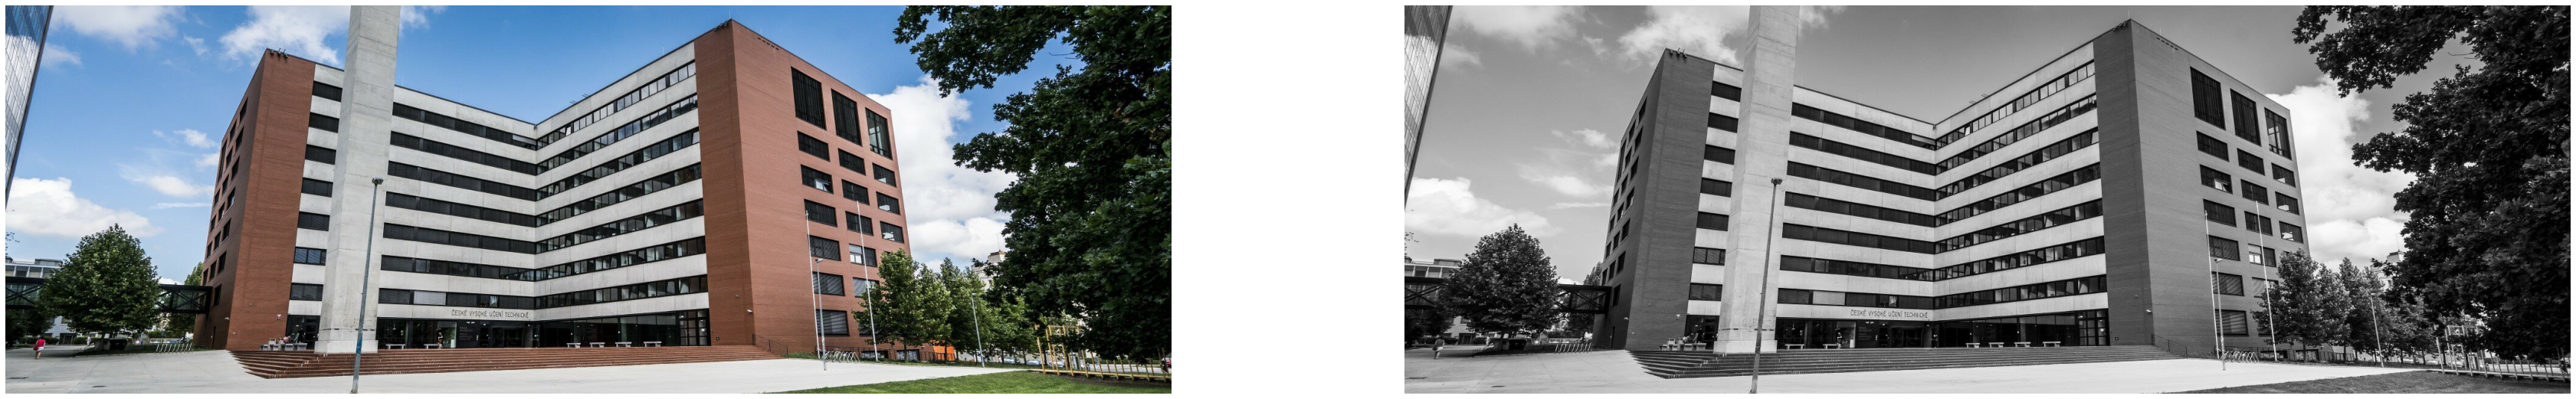

In [8]:
selected_image = select_widget.result
selected_image_gray = improutils.to_gray(select_widget.result)
improutils.plot_images(selected_image, selected_image_gray)

## Example 2
- using `interact` as decorator
- slightly shorter code

In [9]:
def channel_slider(min, max, description):
    return widgets.IntRangeSlider( min=min, max=max, step=1,value=[min,max], 
                                   description=description.ljust(30,'\xa0'), 
                                   continuous_update=False, 
                                   orientation='horizontal',
                                   style=dict(description_width='initial'),
                                   layout=widgets.Layout(width='auto', grid_area='header'),
                                  )
def threshold(img, l_bound, u_bound):
    #return img[(img>=l_bound) & (img <= u_bound)] * 255
    return np.logical_and(img > l_bound, img < u_bound).astype(np.uint8) * 255

In [10]:
@interact(threshold_range = channel_slider( min=0, max=255, description='Threshold range:',))
def _(threshold_range):
    mask = threshold(selected_image_gray, threshold_range[0], threshold_range[1])
    improutils.plot_images(mask, improutils.apply_mask(selected_image, mask))

interactive(children=(IntRangeSlider(value=(0, 255), continuous_update=False, description='Threshold range:\xa…

# TODO: local treshold

# TODO: RGB

# TODO: HSV

In [11]:
from sklearn.cluster import KMeans

# @interact(cluster_count = widgets.IntSlider( min=1, max=255, step=1,value=255))
@interact(cluster_count = widgets.BoundedIntText( min=1, max=255, step=1,value=2))
def _(cluster_count):    
    block_len = 10
    image=selected_image_gray.copy()
    X = image.reshape(-1, 1)

    k = cluster_count
    kmeans= KMeans(n_clusters=k, random_state=42, n_init=3).fit(X)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    restored = np.take(centroids, labels, axis=0)
    final_image = restored.reshape(image.shape).astype('uint8')


    improutils.plot_images(image, final_image)

interactive(children=(BoundedIntText(value=2, description='cluster_count', max=255, min=1), Output()), _dom_cl…

In [12]:
from sklearn.cluster import KMeans

# @interact(cluster_count = widgets.IntSlider( min=1, max=255, step=1,value=255))
@interact(cluster_count = widgets.BoundedIntText( min=1, max=20, step=1,value=2))
def _(cluster_count):    
    block_len = 10
    image=selected_image.copy()
    
    pixel_vals = image.reshape((-1,3)) 
  
    pixel_vals = np.float32(pixel_vals)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
    k = cluster_count
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) 
  
    centers = np.uint8(centers) 
    segmented_data = centers[labels.flatten()] 
  
    segmented_image = segmented_data.reshape((image.shape)) 

    improutils.plot_images(image, segmented_image)

interactive(children=(BoundedIntText(value=2, description='cluster_count', max=20, min=1), Output()), _dom_cla…

In [ ]:
from skimage import data, segmentation, color
from skimage.future import graph

@interact( n_segments=widgets.BoundedIntText( min=1, max=500, step=5,value=200),
           compactness = [0.01, 0.1, 1, 10, 100],
           thresh=widgets.BoundedIntText( min=1, max=100, step=1,value=10),
           mode=['distance', 'similarity'])

def _(n_segments, compactness, thresh, mode):    
    image=selected_image.copy()
    img = image
    labels1 = segmentation.slic(img, compactness=compactness, n_segments=n_segments, start_label=1)
    out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0).astype('uint8')

    g = graph.rag_mean_color(img, labels1, mode=mode)
    labels2 = graph.cut_threshold(labels1, g, thresh)
    out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0).astype('uint8')

    improutils.plot_images(image)
    improutils.plot_images(out1)
    improutils.plot_images(out2)

interactive(children=(BoundedIntText(value=200, description='n_segments', max=500, min=1, step=5), Dropdown(de…